# 🎮 Connect Four: 3-Way A/B Test

**PoH-HRM vs BERT vs Baseline Transformer on A100 GPU**

This notebook compares:
- **Baseline**: Standard Transformer encoder
- **BERT**: Pre-trained BERT architecture (parameter-matched)
- **PoH-HRM**: Pointer-over-Heads with Hierarchical Reasoning Module (f_L + f_H with T=4)

**Task**: Learn to play Connect Four strategically

**Why Connect Four?**
- Requires tactical and strategic planning
- Multi-step lookahead reasoning
- Perfect for testing hierarchical reasoning (HRM's f_L for tactics, f_H for strategy)
- Tests if temporal abstraction helps with game playing

**Parameter Parity**: All models matched to ~1-5% parameter count for fair comparison


## Setup


In [2]:
# Clone repository
!git clone https://github.com/Eran-BA/PoT.git
%cd PoT


Cloning into 'PoT'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 978 (delta 131), reused 166 (delta 64), pack-reused 734 (from 1)
Receiving objects: 100% (978/978), 778.64 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (489/489), done.
/content/PoT


In [3]:
%cd /content/PoT
!git pull origin main


/content/PoT
From https://github.com/Eran-BA/PoT
 * branch            main       -> FETCH_HEAD
Already up to date.


In [4]:
# Install dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets scipy numpy tqdm matplotlib seaborn pandas


Looking in indexes: https://download.pytorch.org/whl/cu118


In [5]:
# Verify GPU
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB" if torch.cuda.is_available() else "N/A")


GPU Available: True
GPU Name: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB


## Run Connect Four A/B Test


In [ ]:
# Quick test (500 training games, minimax depth=3)
!python experiments/connect_four_ab_test.py \
  --train-games 500 \
  --test-games 100 \
  --minimax-depth 3 \
  --epochs 80 \
  --R 4 \
  --T 4 \
  --n-heads 4


In [ ]:
# Full test (1000 games, deeper minimax) - where HRM should shine!
!python experiments/connect_four_ab_test.py \
  --train-games 1000 \
  --test-games 200 \
  --minimax-depth 4 \
  --epochs 120 \
  --R 4 \
  --T 4 \
  --n-heads 4


## Visualize Results


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load results
df = pd.read_csv('experiments/results/connect_four_ab/connect_four_R4_T4_nheads4.csv')

# Display
print("\n📊 Connect Four Results")
print("="*80)
print(df.to_string())

# Plot comparison
plt.figure(figsize=(12, 5))

baseline_data = df[df['model'] == 'Baseline']
poh_data = df[df['model'] == 'PoH-HRM']

# Accuracy comparison
plt.subplot(1, 2, 1)
models = ['Baseline', 'PoH-HRM']
accuracies = [baseline_data['final_accuracy'].values[0], poh_data['final_accuracy'].values[0]]
colors = ['#3498db', '#e74c3c']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.ylabel('Move Prediction Accuracy')
plt.title('Connect Four: Move Prediction Accuracy')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}',
            ha='center', va='bottom', fontweight='bold')

# Training efficiency
plt.subplot(1, 2, 2)
params = [baseline_data['params_M'].values[0], poh_data['params_M'].values[0]]
bars = plt.bar(models, params, color=colors, alpha=0.8)
plt.ylabel('Parameters (M)')
plt.title('Model Size Comparison')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}M',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('connect_four_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate improvements
print("\n🏆 PoH-HRM vs Baseline:")
print("="*80)
baseline_acc = baseline_data['final_accuracy'].values[0]
poh_acc = poh_data['final_accuracy'].values[0]
improvement = ((poh_acc - baseline_acc) / baseline_acc) * 100
print(f"Accuracy: {poh_acc:.1%} vs {baseline_acc:.1%} ({improvement:+.1f}% improvement)")

baseline_params = baseline_data['params_M'].values[0]
poh_params = poh_data['params_M'].values[0]
param_overhead = ((poh_params - baseline_params) / baseline_params) * 100
print(f"Parameters: {poh_params:.2f}M vs {baseline_params:.2f}M ({param_overhead:+.1f}% overhead)")

if poh_acc > baseline_acc:
    print(f"\n✅ PoH-HRM WINS by {(poh_acc - baseline_acc):.1%}!")
elif poh_acc < baseline_acc:
    print(f"\n❌ Baseline wins by {(baseline_acc - poh_acc):.1%}")
else:
    print(f"\n⚖️ TIE!")


## Play Interactive Game (Optional)


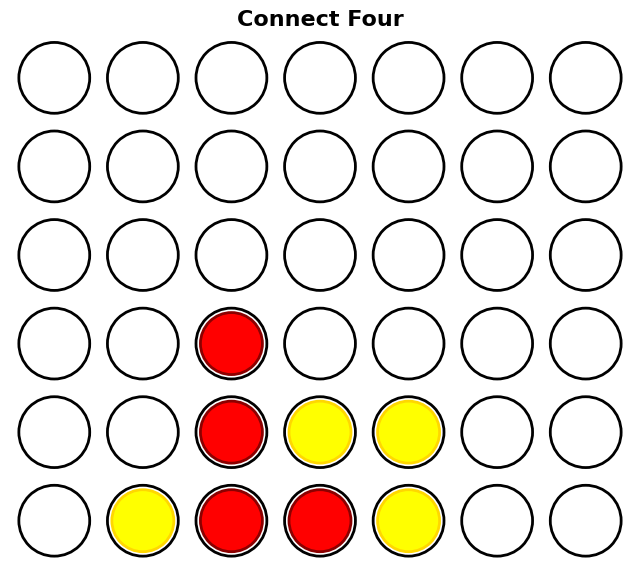

⚖️ Draw!


In [9]:
# Visualize a Connect Four game
import sys
sys.path.insert(0, '.')

from experiments.connect_four_ab_test import ConnectFour
import matplotlib.pyplot as plt
import numpy as np

def draw_board(board):
    """Visualize Connect Four board."""
    fig, ax = plt.subplots(figsize=(8, 7))

    # Draw grid
    for i in range(7):
        for j in range(6):
            circle = plt.Circle((i, 5-j), 0.4, color='white', ec='black', linewidth=2)
            ax.add_patch(circle)

            if board[j, i] == 1:
                circle = plt.Circle((i, 5-j), 0.35, color='red', ec='darkred', linewidth=2)
                ax.add_patch(circle)
            elif board[j, i] == 2:
                circle = plt.Circle((i, 5-j), 0.35, color='yellow', ec='gold', linewidth=2)
                ax.add_patch(circle)

    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 5.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Connect Four', fontsize=16, fontweight='bold')

    return fig, ax

# Play a sample game
game = ConnectFour()
moves = [3, 3, 2, 4, 2, 4, 2, 1]  # Example game

for move in moves:
    if game.make_move(move):
        pass
    if game.game_over:
        break

fig, ax = draw_board(game.board)
plt.savefig('connect_four_sample_game.png', dpi=150, bbox_inches='tight')
plt.show()

if game.winner:
    print(f"🏆 Player {game.winner} wins!")
else:
    print("⚖️ Draw!")


## Download Results


In [10]:
from google.colab import files

# Download CSV results
files.download('experiments/results/connect_four_ab/connect_four_R4_T4_nheads4.csv')

# Download plots
files.download('connect_four_results.png')
files.download('connect_four_sample_game.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>